# Course project


**Основное**
- Дедлайн - 10 июля 23:59
- Целевая метрика precision@5
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. В решении должны быть отчетливо видна метрика на новом тестовом сете из файла retail_test1.csv, то есть вам нужно для всех юзеров из этого файла выдать выши рекомендации, и посчитать на actual покупках precision@5. 

**!! Мы не рассматриваем холодный старт для пользователя, все наши пользователя одинаковы во всех сетах, поэтому нужно позаботиться об их исключении из теста.**


**Hints:** 

Сначала просто попробуйте разные параметры MainRecommender:  
- N в топ-N товарах при формировании user-item матирцы (сейчас топ-5000)  
- Различные веса в user-item матрице (0/1, кол-во покупок, log(кол-во покупок + 1), сумма покупки, ...)  
- Разные взвешивания матрицы (TF-IDF, BM25 - у него есть параметры)  
- Разные смешивания рекомендаций (обратите внимание на бейзлайн - прошлые покупки юзера)  

Сделайте MVP - минимально рабочий продукт - (пусть даже top-popular), а потом его улучшайте

Если вы делаете двухуровневую модель - следите за валидацией 

# Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items, set_frequency_rank_coding, get_replace_dict, set_user_item_features, set_warm_start, preparing_data, get_candidates, get_target_ranker
from src.recommenders import MainRecommender


## Read data

In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

In [3]:
data.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [5]:
data.nunique()

user_id                2499
basket_id            257001
day                     663
item_id               89051
quantity              11246
sales_value            5435
store_id                573
retail_disc            2364
trans_time             1440
week_no                  95
coupon_disc             393
coupon_match_disc        79
dtype: int64

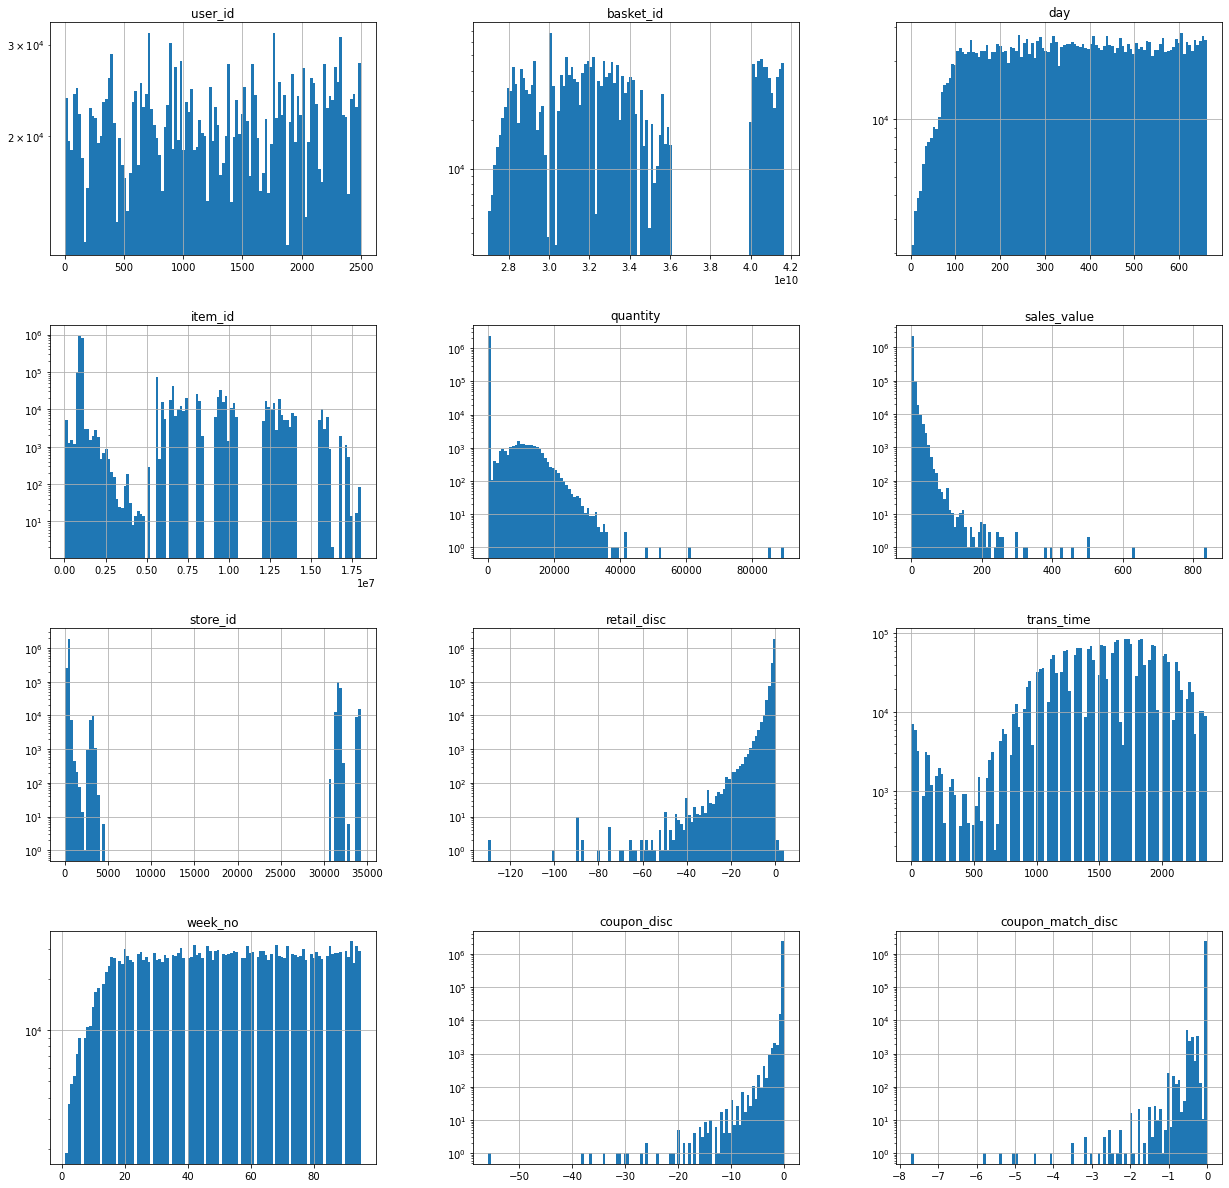

In [6]:
data.hist(figsize=(21,21), bins=111, log=True);

In [7]:
item_features.head(3)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [8]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRODUCT_ID            92353 non-null  int64 
 1   MANUFACTURER          92353 non-null  int64 
 2   DEPARTMENT            92353 non-null  object
 3   BRAND                 92353 non-null  object
 4   COMMODITY_DESC        92353 non-null  object
 5   SUB_COMMODITY_DESC    92353 non-null  object
 6   CURR_SIZE_OF_PRODUCT  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [9]:
item_features.nunique()

PRODUCT_ID              92353
MANUFACTURER             6476
DEPARTMENT                 44
BRAND                       2
COMMODITY_DESC            308
SUB_COMMODITY_DESC       2383
CURR_SIZE_OF_PRODUCT     4345
dtype: int64

In [10]:
user_features.head(3)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [11]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_DESC             801 non-null    object
 1   MARITAL_STATUS_CODE  801 non-null    object
 2   INCOME_DESC          801 non-null    object
 3   HOMEOWNER_DESC       801 non-null    object
 4   HH_COMP_DESC         801 non-null    object
 5   HOUSEHOLD_SIZE_DESC  801 non-null    object
 6   KID_CATEGORY_DESC    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [12]:
user_features.nunique()

AGE_DESC                 6
MARITAL_STATUS_CODE      3
INCOME_DESC             12
HOMEOWNER_DESC           5
HH_COMP_DESC             6
HOUSEHOLD_SIZE_DESC      5
KID_CATEGORY_DESC        4
household_key          801
dtype: int64

# Set global const

In [13]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# N = Neighbors
N_PREDICT = 50 

# Process features dataset

In [14]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [15]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [16]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [17]:
for col_name in user_features.columns.to_list()[:-1]:
    print(f'{col_name}: {user_features[col_name].unique()}')

age_desc: ['65+' '45-54' '25-34' '35-44' '19-24' '55-64']
marital_status_code: ['A' 'U' 'B']
income_desc: ['35-49K' '50-74K' '25-34K' '75-99K' 'Under 15K' '100-124K' '15-24K'
 '125-149K' '150-174K' '250K+' '175-199K' '200-249K']
homeowner_desc: ['Homeowner' 'Unknown' 'Renter' 'Probable Renter' 'Probable Owner']
hh_comp_desc: ['2 Adults No Kids' '2 Adults Kids' 'Single Female' 'Unknown'
 'Single Male' '1 Adult Kids']
household_size_desc: ['2' '3' '4' '1' '5+']
kid_category_desc: ['None/Unknown' '1' '2' '3+']


### Перекодирование признаков user_features

Проверка правильности работы функции

In [18]:
get_replace_dict(user_features.age_desc.unique())

{'65+': 65, '45-54': 50, '25-34': 30, '35-44': 40, '19-24': 22, '55-64': 60}

In [19]:
get_replace_dict(user_features.income_desc.unique())

{'35-49K': 42,
 '50-74K': 62,
 '25-34K': 30,
 '75-99K': 87,
 'Under 15K': 14,
 '100-124K': 112,
 '15-24K': 20,
 '125-149K': 137,
 '150-174K': 162,
 '250K+': 265,
 '175-199K': 187,
 '200-249K': 224}

In [20]:
get_replace_dict(user_features.household_size_desc.unique())

{'2': 2, '3': 3, '4': 4, '1': 1, '5+': 5}

In [21]:
get_replace_dict(user_features.kid_category_desc.unique())

{'None/Unknown': 0, '1': 1, '2': 2, '3+': 3}

In [22]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [23]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   user_id              801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


### Перекодирование признаков item_features

In [24]:
item_features.nunique()

item_id                 92353
manufacturer             6476
department                 44
brand                       2
commodity_desc            308
sub_commodity_desc       2383
curr_size_of_product     4345
dtype: int64

In [25]:
item_features.brand.head()

0    National
1    National
2     Private
3     Private
4     Private
Name: brand, dtype: object

# Split dataset for train, eval, test

In [26]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [27]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [28]:
users_train_matcher = data_train_matcher[USER_COL].unique()
users_train_ranker = data_train_ranker[USER_COL].unique()
users_val_ranker = data_val_ranker[USER_COL].unique()

new_users_train_ranker = list(set(users_train_ranker) - set(users_train_matcher))
new_users_val_ranker = list(set(users_val_ranker) - (set(users_train_matcher) | set(users_train_ranker)))

add_to_ranker = list(set(users_val_ranker) - (set(users_train_ranker)))

new_users_train_ranker, new_users_val_ranker, len(add_to_ranker)

([1984], [], 126)

In [29]:
# сделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [30]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [31]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [32]:
# выше видим разброс по пользователям и товарам и дальше мы перейдем к warm-start (только известные пользователи)

In [33]:
data_val_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


# Prefilter items

In [34]:
n_items_before = data_train_matcher[USER_COL].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher[ITEM_COL].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

D:\programming\jupyter_dir\educations\рекомендацилнные системы\rec(31.05.2021)\course_project\src\utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 2498 to 5001


In [35]:
data_train_matcher.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.0,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,999999,1,2.99,31742,-0.4,1520,1,0.0,0.0,2.99


## Генерирование новых признаков

In [36]:
user_features.age_desc.replace(
    get_replace_dict(user_features.age_desc.unique()),
    inplace=True)
     
user_features.marital_status_code.replace(
    {'U': 0, 'A': 1, 'B': 2},
    inplace=True)
     
user_features.income_desc.replace(
    get_replace_dict(user_features.income_desc.unique()),
    inplace=True)

user_features.homeowner_desc.replace(
    {'Unknown': 0, 'Probable Renter': 1, 'Renter': 2,
     'Probable Owner': 3, 'Homeowner': 4},
    inplace=True)

user_features.hh_comp_desc.replace(
    {'Unknown': 0, 'Single Male': 1, 'Single Female': 2,
     '1 Adult Kids': 3, '2 Adults No Kids': 4, '2 Adults Kids':5},
    inplace=True)

user_features.household_size_desc.replace(
    get_replace_dict(user_features.household_size_desc.unique()),
    inplace=True) 

user_features.kid_category_desc.replace(
    get_replace_dict(user_features.kid_category_desc.unique()),
    inplace=True)

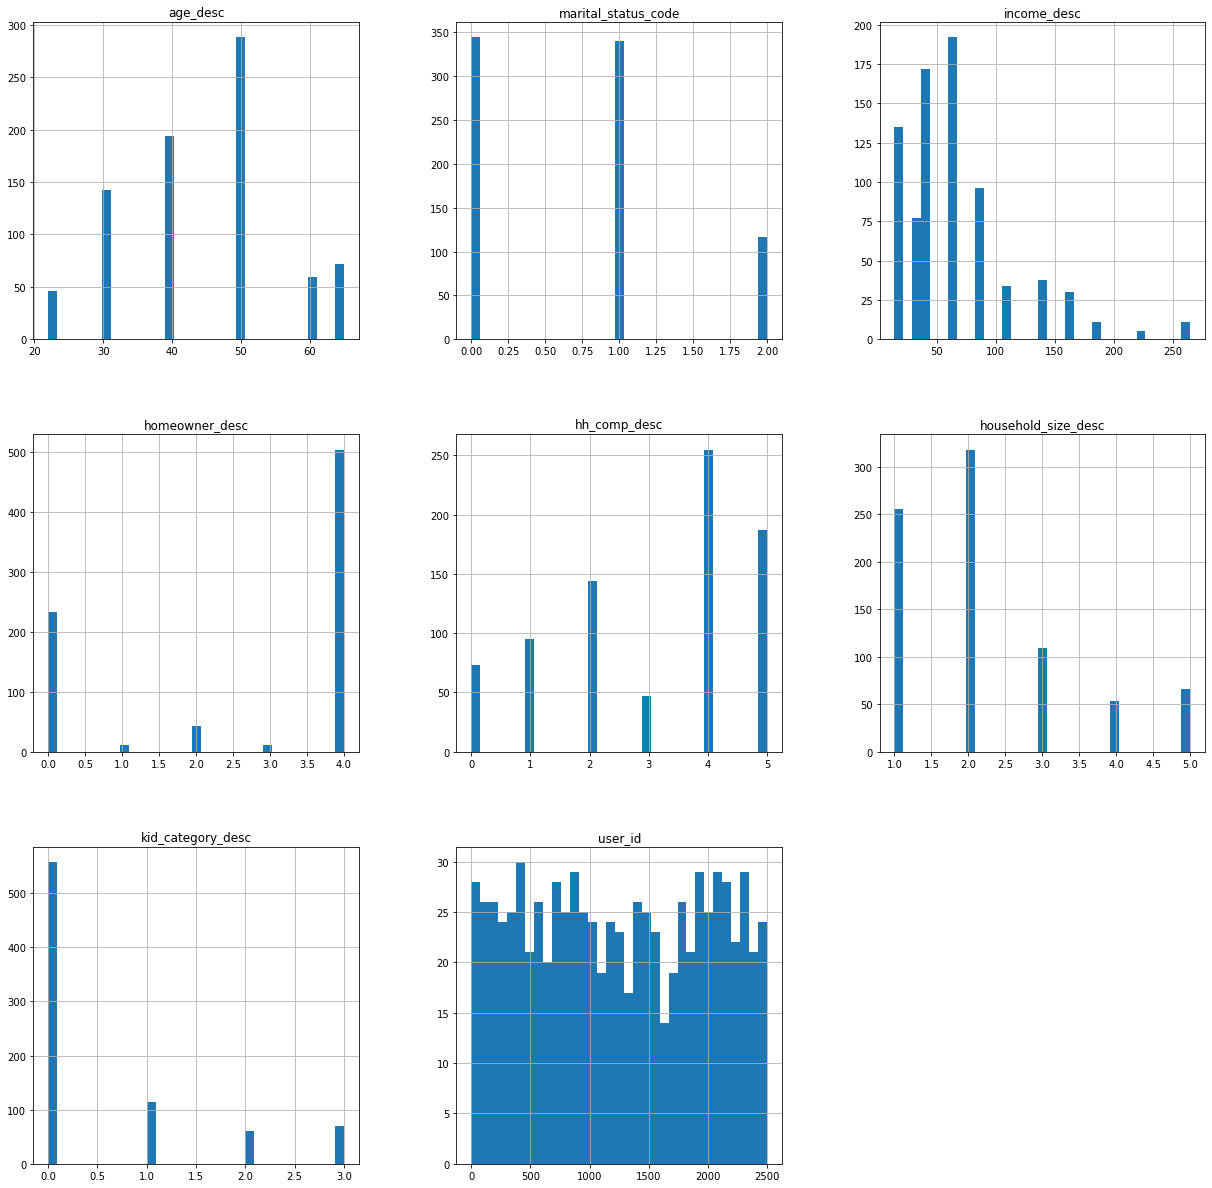

In [37]:
user_features.hist(figsize=(21,21), bins=33);

In [38]:
user_features_names = user_features.columns.tolist()

In [39]:
item_features.brand = np.where(item_features.brand == 'Private', 0, 1)
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,1,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,1,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,0,BREAD,BREAD:ITALIAN/FRENCH,


In [40]:
item_col_list = item_features.columns.drop(['item_id', 'brand']).to_list()
item_col_list

['manufacturer',
 'department',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product']

### Частотное и ранговое кодирование item_features(тест на commodity_desc присел к повышению скора на 0.0009399477806788792)

In [41]:
[set_frequency_rank_coding(item_features, col_name) for col_name in item_col_list]

[set_frequency_rank_coding(item_features, col_name, frequency=False) for col_name in item_col_list]
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,manufacturer_freq,department_freq,commodity_desc_freq,sub_commodity_desc_freq,curr_size_of_product_freq,manufacturer_rank,department_rank,commodity_desc_rank,sub_commodity_desc_rank,curr_size_of_product_rank
0,25671,2,GROCERY,1,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,1411.0,39021.0,29.0,29.0,12.0,1.0,0.0,269.0,814.0,505.0
1,26081,2,MISC. TRANS.,1,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,1411.0,490.0,490.0,429.0,30607.0,1.0,11.0,56.0,13.0,0.0
2,26093,69,PASTRY,0,BREAD,BREAD:ITALIAN/FRENCH,,12676.0,2149.0,343.0,107.0,30607.0,0.0,8.0,91.0,218.0,0.0


In [42]:
item_features_names = item_features.columns.tolist()

In [43]:
user_item_features = set_user_item_features(data_train_matcher, user_features, item_features)
user_item_features.head(3)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

,user_id,item_id,median_hour_transactions,median_weekday_transactions,sum_user_sales_value,item_count,count_transactions_user,mean_check_in_basket,nuniq_item,nuniq_stores,...,user_factor_11,user_factor_12,user_factor_13,user_factor_14,user_factor_15,user_factor_16,user_factor_17,user_factor_18,user_factor_19,user_factor_20
0,1,823721,13.0,4.0,2245.23,661,661,37.4205,172,94,...,-3.586222,-0.134962,5.751214,18.477634,-8.270138,11.557922,-1.938051,-2.302263,-2.175621,8.968863
1,1,823990,15.0,6.0,2245.23,661,661,37.4205,172,95,...,-3.586222,-0.134962,5.751214,18.477634,-8.270138,11.557922,-1.938051,-2.302263,-2.175621,8.968863
2,1,825123,17.0,3.0,2245.23,661,661,37.4205,172,29,...,-3.586222,-0.134962,5.751214,18.477634,-8.270138,11.557922,-1.938051,-2.302263,-2.175621,8.968863


In [44]:
user_item_features_names = user_item_features.columns.tolist()

# Make cold-start to warm-start

In [45]:
data_train_matcher, data_val_matcher, data_train_ranker , data_val_ranker = set_warm_start(data_train_matcher, data_val_matcher, data_train_ranker , data_val_ranker)

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (784420, 13) Users: 1915 Items: 4999
val_matcher
Shape: (163261, 12) Users: 1915 Items: 27118
train_ranker
Shape: (163261, 12) Users: 1915 Items: 27118
val_ranker
Shape: (115989, 12) Users: 1915 Items: 24042


# Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

- Обучаем на data_train_ranking
- Обучаем *только* на выбранных кандидатах
- Я *для примера* сгенерирую топ-50 кадидиатов через get_own_recommendations
- (!) Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [46]:
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [47]:
N_PREDICT=50
targets_ranker = get_target_ranker(data_train_matcher,
                                   data_train_ranker,
                                   item_features,
                                   user_features,
                                   user_item_features,
                                   N_PREDICT)

print(f'число пользователей: {targets_ranker.user_id.nunique()}')
print(f'среднее число покупок: {round(targets_ranker["target"].mean(), 4)}')

targets_ranker.head(2)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

число пользователей: 1915
среднее число покупок: 0.192


,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,manufacturer_freq,...,user_factor_11,user_factor_12,user_factor_13,user_factor_14,user_factor_15,user_factor_16,user_factor_17,user_factor_18,user_factor_19,user_factor_20
0,2070,1105426,0.0,69,DELI,0,SANDWICHES,SANDWICHES - (COLD),,12676.0,...,-8.239985,-8.822578,2.021116,5.640451,0.321459,1.724801,2.843183,0.984791,-2.571941,-1.063783
1,2070,1097350,0.0,2468,GROCERY,1,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,299.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Отбор признаков

In [48]:
item_features_names

['item_id',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'manufacturer_freq',
 'department_freq',
 'commodity_desc_freq',
 'sub_commodity_desc_freq',
 'curr_size_of_product_freq',
 'manufacturer_rank',
 'department_rank',
 'commodity_desc_rank',
 'sub_commodity_desc_rank',
 'curr_size_of_product_rank']

In [49]:
selected_feature_names = [_ for _ in item_features_names if _.endswith(('_freq', 'nd', 'rank', 'er'))]
selected_feature_names

['manufacturer',
 'brand',
 'manufacturer_freq',
 'department_freq',
 'commodity_desc_freq',
 'sub_commodity_desc_freq',
 'curr_size_of_product_freq',
 'manufacturer_rank',
 'department_rank',
 'commodity_desc_rank',
 'sub_commodity_desc_rank',
 'curr_size_of_product_rank']

In [50]:
selected_feature_names.extend(user_features_names[:-1])
selected_feature_names

['manufacturer',
 'brand',
 'manufacturer_freq',
 'department_freq',
 'commodity_desc_freq',
 'sub_commodity_desc_freq',
 'curr_size_of_product_freq',
 'manufacturer_rank',
 'department_rank',
 'commodity_desc_rank',
 'sub_commodity_desc_rank',
 'curr_size_of_product_rank',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [51]:
_ = [_ for _ in user_item_features_names if _.startswith(('median', 'nuniq', 'factor', 'user_factor'))  or _.endswith(('basket', 'count'))]
selected_feature_names.extend(_)
selected_feature_names

['manufacturer',
 'brand',
 'manufacturer_freq',
 'department_freq',
 'commodity_desc_freq',
 'sub_commodity_desc_freq',
 'curr_size_of_product_freq',
 'manufacturer_rank',
 'department_rank',
 'commodity_desc_rank',
 'sub_commodity_desc_rank',
 'curr_size_of_product_rank',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'median_hour_transactions',
 'median_weekday_transactions',
 'item_count',
 'mean_check_in_basket',
 'nuniq_item',
 'nuniq_stores',
 'mean_nunique_items_in_basket',
 'max_nunique_items_in_basket',
 'std_nunique_items_in_basket',
 'mean_items_categories_in_basket',
 'max_items_categories_in_basket',
 'std_items_categories_in_basket',
 'factor_1',
 'factor_2',
 'factor_3',
 'factor_4',
 'factor_5',
 'factor_6',
 'factor_7',
 'factor_8',
 'factor_9',
 'factor_10',
 'factor_11',
 'factor_12',
 'factor_13',
 'factor_14',
 'factor_15',
 'factor_16',
 'factor_17',
 'factor_18',
 'factor_19

In [52]:
categorical = ['marital_status_code','homeowner_desc', 'hh_comp_desc', 'manufacturer']
categorical.extend([_ for _ in item_features_names if _.endswith('_rank')])
categorical

['marital_status_code',
 'homeowner_desc',
 'hh_comp_desc',
 'manufacturer',
 'manufacturer_rank',
 'department_rank',
 'commodity_desc_rank',
 'sub_commodity_desc_rank',
 'curr_size_of_product_rank']

## Models CatBoost and LightGBM

In [53]:
selected_feature_names_cb = [i for i in selected_feature_names if not i in categorical]
selected_feature_names_cb

['brand',
 'manufacturer_freq',
 'department_freq',
 'commodity_desc_freq',
 'sub_commodity_desc_freq',
 'curr_size_of_product_freq',
 'age_desc',
 'income_desc',
 'household_size_desc',
 'kid_category_desc',
 'median_hour_transactions',
 'median_weekday_transactions',
 'item_count',
 'mean_check_in_basket',
 'nuniq_item',
 'nuniq_stores',
 'mean_nunique_items_in_basket',
 'max_nunique_items_in_basket',
 'std_nunique_items_in_basket',
 'mean_items_categories_in_basket',
 'max_items_categories_in_basket',
 'std_items_categories_in_basket',
 'factor_1',
 'factor_2',
 'factor_3',
 'factor_4',
 'factor_5',
 'factor_6',
 'factor_7',
 'factor_8',
 'factor_9',
 'factor_10',
 'factor_11',
 'factor_12',
 'factor_13',
 'factor_14',
 'factor_15',
 'factor_16',
 'factor_17',
 'factor_18',
 'factor_19',
 'factor_20',
 'user_factor_1',
 'user_factor_2',
 'user_factor_3',
 'user_factor_4',
 'user_factor_5',
 'user_factor_6',
 'user_factor_7',
 'user_factor_8',
 'user_factor_9',
 'user_factor_10',
 'u

In [57]:
def run_model(targets_ranker, selected_feature_names, model='cb' ):    
    """run model for CatBoost(model='cb') or LightGBM(model='lgb')"""
    X_train, X_valid, y_train, y_valid = train_test_split(targets_ranker[selected_feature_names].fillna(0),
                                                          targets_ranker[['target']],
                                                          test_size=0.2, random_state=21,
                                                          stratify=targets_ranker[['target']])
   
    if model=='cb':
        dtrain = Pool(data=X_train, label=y_train) #, cat_features=categorical
        dvalid = Pool(data=X_valid, label=y_valid) #, cat_features=categorical

        params_cb = {"n_estimators":1000,
                 "learning_rate": 0.1,
                 "loss_function": "Logloss",
                 "eval_metric": "AUC",
                 "task_type": "CPU",
                 "max_bin": 30,
                 "early_stopping_rounds": 30,
                 "verbose": 1000,
                 "max_depth": 10,
                 "l2_leaf_reg": 80,
                 "thread_count": -1,
                 "random_seed": 21} 

        model_cb = CatBoostClassifier(**params_cb)
        model_cb.fit(dtrain, eval_set=[dvalid])
        return model_cb
    
    elif model=='lgb':
        dtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical)
        dvalid = lgb.Dataset(X_valid, y_valid, categorical_feature=categorical)

        params_lgb = {"boosting_type": "gbdt",
                  "objective": "binary", 
                  "metric": "auc",
                  "num_boost_round": 1000,
                  "learning_rate": 0.1,
                  "class_weight": 'balanced',
                  "max_depth": 10,
                  "n_estimators": 5000,
                  "n_jobs": 6,
                  "seed": 21} 

        model_lgb = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dvalid],
                          categorical_feature=categorical,
                          verbose_eval=1000,
                          early_stopping_rounds=30)
        return model_lgb
    else:
        return False


## Run models and get predictions

In [55]:
model_lgb = run_model(targets_ranker, selected_feature_names, model='lgb')

D:\programming\anaconda3\lib\site-packages\lightgbm-3.2.1-py3.8-win-amd64.egg\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
D:\programming\anaconda3\lib\site-packages\lightgbm-3.2.1-py3.8-win-amd64.egg\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1354964, number of negative: 5700484
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.967024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15760
[LightGBM] [Info] Number of data points in the train set: 7055448, number of used features: 71


D:\programming\anaconda3\lib\site-packages\lightgbm-3.2.1-py3.8-win-amd64.egg\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\programming\anaconda3\lib\site-packages\lightgbm-3.2.1-py3.8-win-amd64.egg\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192045 -> initscore=-1.436776
[LightGBM] [Info] Start training from score -1.436776
Training until validation scores don't improve for 30 rounds
[1000]	training's auc: 0.999518	valid_1's auc: 0.999512
[2000]	training's auc: 0.999946	valid_1's auc: 0.999943
[3000]	training's auc: 0.99998	valid_1's auc: 0.999977
[4000]	training's auc: 0.999982	valid_1's auc: 0.999979
Early stopping, best iteration is:
[4146]	training's auc: 0.999982	valid_1's auc: 0.999979


In [ ]:
model_cb = run_model(targets_ranker, selected_feature_names_cb)

0:	test: 0.7731025	best: 0.7731025 (0)	total: 4.59s	remaining: 1h 16m 24s


In [ ]:
predictions_lgb_train = model_lgb.predict(targets_ranker[selected_feature_names].fillna(0))
predictions_cb_train = model_cb.predict_proba(targets_ranker[selected_feature_names_cb].fillna(0))[:, 1]

In [ ]:
preds_train = pd.DataFrame(zip(predictions_lgb_train, 
                               predictions_cb_train),
                           columns=['lgb', 'cb']).mean(axis=1).values
roc_auc_score(targets_ranker['target'], preds_train)

## Prediction processing 

In [ ]:
def get_predictions(targets_ranker, raw_predictions, prefix='lgb'): 
    df = targets_ranker[['user_id', 'item_id']]
    df['predictions'] = raw_predictions

    df = df.groupby(['user_id', 'item_id'])['predictions'].median().reset_index()
    df = df.sort_values(['predictions'], ascending=False).groupby(['user_id']).head(5)

    df = df.groupby('user_id')['item_id'].unique().reset_index()
    df.columns = ['user_id', prefix + '_recommendations']
    
    return df

def get_results(data_val_ranker, targets_ranker, preds_lgb, preds_cb, combined_preds):
    result = data_val_ranker.groupby('user_id')['item_id'].unique().reset_index()
    result.columns=['user_id', 'actual']
    
    prefixes = ['lgb', 'cb', 'cb_lgb']
    predictions = [preds_lgb, preds_cb, combined_preds]
    
    for i, preds in enumerate(predictions):
        df = get_predictions(targets_ranker, preds, prefixes[i])
        result = result.merge(df, on='user_id', how='left')

    return result

In [ ]:
result_ranker = get_results(data_val_ranker, targets_ranker, 
                           predictions_lgb_train,
                           predictions_cb_train, 
                           preds_train)
result_ranker.head(2)

## Getting metrics 

### *LightGBM metrics*

In [ ]:
result_ranker.apply(lambda row: precision_at_k(row['lgb_recommendations'], row['actual'], 5), axis=1).mean()


### *CatBoost metrics* 

In [ ]:
result_lvl_2.apply(lambda row: precision_at_k(row['cb_recommendations'], row['actual'], 5), axis=1).mean()


### *Ensemble metrics*

In [ ]:
result_ranker.apply(lambda row: precision_at_k(row['cb_lgb_recommendations'], row['actual'], 5), axis=1).mean()


In [ ]:
a()

## Building final predictions 

### *Финальные прогнозы строятся на всей обучающей выборке*

In [ ]:
test = pd.read_csv('../data/retail_test1.csv')
test.head(2

In [ ]:
validation_weeks = 6
data_train = data[data['week_no'] < data['week_no'].max() - validation_weeks]
data_valid = data[data['week_no'] >= data['week_no'].max() - validation_weeks]

In [ ]:
users_train = data_train.user_id.unique()
users_valid = data_valid.user_id.unique()
users_test = test.user_id.unique()

new_users_valid = list(set(users_valid) - set(users_train))
new_users_test = list(set(users_lvl_3) - (set(users_train) | set(users_valid)))

add_to_valid = list(set(users_test) - (set(users_valid)))

new_users_valid, new_users_test, len(add_to_valid)

### *Make cold-start to warm-start*

In [ ]:
data_train, data_valid, test  = set_warm_start(data_train, data_valid, None, test, test=True)

print_stats_data(data_train,'train')
print_stats_data(data_valid,'valid')
print_stats_data(test,'test')

In [ ]:
n_items_before = data['item_id'].nunique()
data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=5000)
n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

In [ ]:
user_item_features = set_user_item_features(data_train, user_features, item_features)
user_item_features.head(2)

In [ ]:
targets_test = get_target_ranker(data_train,
                                 data_valid,
                                 item_features,
                                 user_features,
                                 user_item_features,
                                 N_PREDICT)

print(f'число пользователей: {targets_test.user_id.nunique()}')
print(f'среднее число покупок: {round(targets_test["target"].mean(), 4)}')

targets_test.head(2)

Генерация прогнозов

In [ ]:
model_lgb = run_model(targets_test, selected_feature_names, model='lgb')

In [ ]:
model_cb = run_model(targets_test, selected_feature_names_cb)

In [ ]:
predictions_lgb_test = model_lgb.predict(targets_test[selected_feature_names].fillna(0))
predictions_cb_test = model_cb.predict_proba(targets_test[selected_feature_names_cb].fillna(0))[:, 1]

In [ ]:
preds_test = pd.DataFrame(zip(predictions_lgb_test, predictions_cb_test),columns=['lgb', 'cb']).mean(axis=1).values
roc_auc_score(targets_test['target'], preds_test)

## Prediction processing 

In [ ]:
result_test = get_results(test,
                          targets_test,
                          predictions_lgb_test,
                          predictions_cb_test,
                          preds_test)
result_test.head(2)

## Getting metrics 

### *LightGBM metrics*

In [ ]:
result_test.apply(lambda row: precision_at_k(row['lgb_recommendations'], row['actual'], 5), axis=1).mean()


### *CatBoost metrics* 

In [ ]:
result_test.apply(lambda row: precision_at_k(row['cb_recommendations'], row['actual'], 5), axis=1).mean()


### *Ensemble metrics*

In [ ]:
result_test.apply(lambda row: precision_at_k(row['cb_lgb_recommendations'], row['actual'], 5), axis=1).mean()


In [ ]:
PATH = './'
df = result_test[['user_id', 'cb_recommendations']].copy()
df.to_csv(PATH + 'predictions/predictions_cb_3338.csv', index=False)
df.head(2)

In [ ]:
models = [model_cb, model_lgb]
for i, name in enumerate(['model_cb.pkl', 'model_lgb.pkl']):
    filename = PATH + '/models/' + '3338_' + name
    pickle.dump(models[i], open(filename, 'wb'))

In [ ]:
targets_test.to_csv(PATH + 'data_for_prediction/3338_targets_test.csv')
